# GalSampler Demo

This notebook gives a simple demo of the two core functions in galsampler: `crossmatch` and `galsample`. We'll start out by using `crossmatch` to create a toy mock catalog of galaxies, and then we'll use `galsample` to galsample the toy mock into a different halo catalog.

## Using the `crossmatch` function

We'll start out by creating a dummy catalog of dark matter halos, and then use `crossmatch` to populate these halos with mock galaxies. Later in this demo, we'll use this same mock galaxy catalog to demonstrate galsampling.

In [1]:
import numpy as np

n_source_halos = 1000
source_halo_ids = np.arange(n_source_halos).astype(int)
source_halo_lgmass = np.random.uniform(10, 15, n_source_halos)
source_halo_spin = 10**np.random.uniform(-2, 0, n_source_halos)
source_halo_ellipticity = np.random.uniform(0, 1, n_source_halos)

The halos in our dummy catalog have three physical properties: mass, spin, and ellipticity. We'll now create a mock catalog of $50,000$ galaxies that populate these halos, simply by randomly selecting halo IDs that our galaxies will populate.

In [2]:
n_source_gals = 50_000
source_gals_host_halo_id = np.random.choice(
    source_halo_ids, size=n_source_gals)

Using the host halo ID for each of our mock galaxies. We'll now use the `crossmatch` function to transfer the host halo mass to each of the galaxies. The `crossmatch` function returns two indexing arrays that provide the correspondence between two catalogs sharing a common ID:

In [3]:
from galsampler import crossmatch

idxA, idxB = crossmatch(
    source_gals_host_halo_id, source_halo_ids)

source_gals_halo_lgmass = np.zeros(n_source_gals)
source_gals_halo_lgmass[idxA] = source_halo_lgmass[idxB]

Note that since `crossmatch` just returns indexing arrays, at this point we could similarly broadcast the host halo spin and ellipticity to each of the source galaxies. But for our present purposes, let's just stick with halo mass.

Finally, let's make our mock a little more interesting and map stellar mass onto each mock galaxy. To do this, we'll just use a lognormal distribution determined by the host halo mass. This is unrealistic because it does not distinguish between centrals and satellites, but this is just a toy model that we're setting up for demonstration purposes.

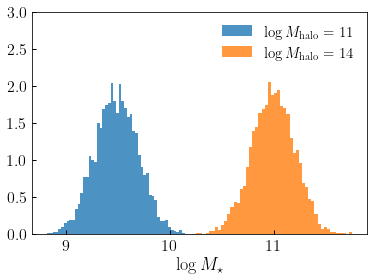

In [4]:
from matplotlib import pyplot as plt

def median_logsm_from_lgmass(lgmass):
    return 10 + 0.5*(lgmass-12)

med_logsm = median_logsm_from_lgmass(source_gals_halo_lgmass)
source_gals_logsm = np.random.normal(loc=med_logsm, scale=0.2)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 3)
msk1 = np.abs(source_gals_halo_lgmass-11) < 0.2
__=ax.hist(source_gals_logsm[msk1], bins=50, density=True, 
           alpha=0.8, label=r'$\log M_{\rm halo}=11$')
msk2 = np.abs(source_gals_halo_lgmass-14) < 0.2
__=ax.hist(source_gals_logsm[msk2], bins=50, density=True, 
           alpha=0.8, label=r'$\log M_{\rm halo}=14$')
leg = ax.legend()
xlabel = ax.set_xlabel(r'$\log M_{\star}$')

## Using the `galsample` function to transfer galaxies from one halo catalog to another

First let's set up another dummy catalog of dark matter halos:

In [5]:
n_target_halos = 5000
target_halo_ids = np.arange(n_target_halos).astype(int)
target_halo_lgmass = np.random.uniform(10, 15, n_target_halos)
target_halo_spin = 10**np.random.uniform(-2, 0, n_target_halos)
target_halo_zhalf = np.random.uniform(0.1, 5, n_target_halos)

Halos in our target halo catalog have three physical properties: mass, spin, and the redshift at which they formed half of their present-day mass.

Now we'll use the mass and spin to provide a correspondence between halos in the two catalogs, so that for each halo in the target halo catalog, we have a closely-matching counterpart in the source halo catalog. Once that correspondence is set up, we populate each target halo by transferring the galaxy content of its counterpart source halo. The `galsample` function provides the indexing array for this operation:

In [6]:
from galsampler import galsample

source_halo_props = (source_halo_lgmass, source_halo_spin)
target_halo_props = (target_halo_lgmass, target_halo_spin)

gs_results = galsample(
    source_gals_host_halo_id,
    source_halo_ids, target_halo_ids,
    source_halo_props, target_halo_props)

n_target_gals = len(gs_results.target_gals_selection_indx)

The `galsample` function returns three arrays of integers, each with the same length $N_{\rm gals, target}$:

- `target_gals_selection_indx` is an indexing array into the source galaxy catalog. Each entry in this array provides the index of a source galaxy that has been selected for membership in the target galaxy catalog.

- `target_gals_target_halo_ids` stores the halo ID of the target halo that hosts each galaxy

- `target_gals_source_halo_ids` stores the halo ID of the source halo that each galaxy came from

First let's use the `target_gals_selection_indx` to get the stellar mass and host halo mass of our target galaxies:

In [7]:
target_gals_source_halo_lgmass = source_gals_halo_lgmass[gs_results.target_gals_selection_indx]
target_gals_logsm = source_gals_logsm[gs_results.target_gals_selection_indx]

Now let's verify that the distribution of stellar masses as a function of host halo mass has been preserved by our galsampling:

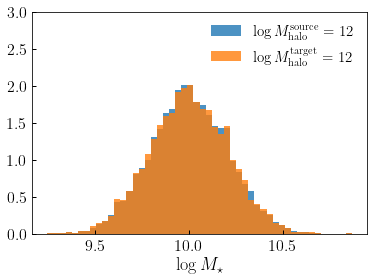

In [8]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 3)
lgm = 12
msk1 = np.abs(source_gals_halo_lgmass-lgm) < 0.2
__=ax.hist(source_gals_logsm[msk1], 
           bins=50, density=True, alpha=0.8, 
           label=r'$\log M^{\rm source}_{\rm halo}=12$')

msk1b = np.abs(target_gals_source_halo_lgmass-lgm) < 0.2
__=ax.hist(target_gals_logsm[msk1b], 
           bins=50, density=True, alpha=0.8, 
           label=r'$\log M^{\rm target}_{\rm halo}=12$')
leg = ax.legend()
xlabel = ax.set_xlabel(r'$\log M_{\star}$')

### Inheriting additional halo properties with `crossmatch`

So far we have seen how to use `target_gals_selection_indx` to paint stellar mass and host halo mass onto our target galaxies. But what if we want our target galaxies to inherit additional properties from their source/target halos? For the case of the halo mass of the source halos, this was made easy by the fact that our original source galaxy catalog already had the halo masses broadcast to the galaxies. But our source galaxy catalog did not have such broadcasting for the case of halo spin or ellipticity. And our target halos have an additional formation-redshift property that we may also want to bestow upon our target galaxies. In order to inherit these properties, we'll make use of the other two arguments returned by the `galsample` function, together with one final use of `crossmatch`.

In [9]:
idxA, idxB = crossmatch(
    gs_results.target_gals_target_halo_ids, target_halo_ids)

target_gals_target_halo_zhalf = np.zeros(n_target_gals)
target_gals_target_halo_zhalf[idxA] = target_halo_zhalf[idxB]

In [10]:
idxA, idxB = crossmatch(
    gs_results.target_gals_source_halo_ids, source_halo_ids)

target_gals_source_halo_spin = np.zeros(n_target_gals)
target_gals_source_halo_spin[idxA] = source_halo_spin[idxB]